In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error


In [24]:
#setting random seed
seed = 42
import random
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.use_deterministic_algorithms(True)

In [25]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [26]:
# data_prep 에서 train/test split한 pivot table

train_scaled = pd.read_csv("./reindex_train_scaled.csv",index_col=0)
test_scaled = pd.read_csv("./reindex_test_scaled.csv",index_col=0)
# val_scaled = pd.read_csv("./val_scaled.csv",index_col=0)

train = pd.read_csv("./train_orig.csv",index_col=0)
# val = pd.read_csv("./val_orig.csv",index_col=0)
test = pd.read_csv("./test_orig.csv",index_col=0)

In [27]:
#load lists
import pickle

dir = './features/'
with open(dir+'avoid_list_orig.pickle','rb') as f:
    avoid_list_orig = pickle.load(f)
with open(dir+'city_info.pickle','rb') as f:
    city_info = pickle.load(f)
with open(dir+'strata_info.pickle','rb') as f:
    strata_info = pickle.load(f)
with open(dir+'heuristic_list.pickle','rb') as f:
    heuristic_list = pickle.load(f)
with open(dir+'target_cand.pickle','rb') as f:
    target_cand = pickle.load(f)
with open(dir+'targetspecific_list.pickle','rb') as f:
    targetspecific_list = pickle.load(f)

target_list = target_cand

In [28]:
heuristic_col = list()
for values in heuristic_list.values():
    heuristic_col.extend(values)
set(heuristic_col)

col_cand_list=[
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Income | Per-capita Household Income',
    'Language and Nativity | Primarily Speak English',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Cancer | All Cancer Deaths',
    'Cancer | Breast Cancer Deaths',
    'Cancer | Lung Cancer Deaths',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Language and Nativity | Primarily Speak Spanish',
    'Births | Teen Births',
    'Cancer | All Cancer Deaths',
    'Cancer | Breast Cancer Deaths',
    'Cancer | Lung Cancer Deaths',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Heat and Disasters | Community Social Vulnerability to Climate Disasters',
    'Income-related | Unemployment',
    'Language and Nativity | Primarily Speak Spanish',
    'Mental Health | Suicide',
    'Race/Ethnicity | Minority Population',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Income | Per-capita Household Income',
    'Language and Nativity | Primarily Speak English',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Income | Per-capita Household Income',
    'Language and Nativity | Primarily Speak English',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Income | Per-capita Household Income',
    'Language and Nativity | Primarily Speak English',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Diabetes and Obesity | Diabetes Deaths',
    'Life Expectancy at Birth | Life Expectancy',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Diabetes and Obesity | Diabetes Deaths',
    'Language and Nativity | Foreign Born Population',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Adult Mental Distress',
    'Racial Segregation Indices | Racial Segregation, White and Non-White',
    'Respiratory Infection | COVID-19 Deaths',
    'Respiratory Infection | New Tuberculosis Cases',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Diabetes and Obesity | Diabetes Deaths',
    'Life Expectancy at Birth | Life Expectancy',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Diabetes and Obesity | Diabetes Deaths',
    'Language and Nativity | Foreign Born Population',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Adult Mental Distress',
    'Racial Segregation Indices | Racial Segregation, White and Non-White',
    'Respiratory Infection | COVID-19 Deaths',
    'Respiratory Infection | New Tuberculosis Cases',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Premature Death',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Suicide',
    'Substance Use | Drug Overdose Deaths',
    'Substance Use | Opioid Overdose Deaths',
    'Crime Incidents | Homicides',
    'Deaths | Deaths from All Causes',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Food Access | Limited Supermarket Access',
    'Language and Nativity | Foreign Born Population',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Suicide',
    'Sexually Transmitted Disease | New Gonorrhea Cases',
    'Substance Use | Drug Overdose Deaths',
    'Substance Use | Opioid Overdose Deaths',
    'Active Transportation | Walking to Work',
    'Deaths | Deaths from All Causes',
    'Deaths | Premature Death',
    'Education | Preschool Enrollment',
    'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
    'Transportation | Public Transportation Use',
    'Active Transportation | Walking to Work',
    'Deaths | Deaths from All Causes',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Education | Preschool Enrollment',
    'Heat and Disasters | Longer Summers',
    'Income-related | Service Workers',
    'Language and Nativity | Primarily Speak Chinese',
    'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
    'Mental Health | Suicide',
    'Transportation | Public Transportation Use',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Crime Incidents | Homicides',
    'Deaths | Deaths from All Causes',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Injury Deaths',
    'Life Expectancy at Birth | Life Expectancy',
    'Births | Low Birthweight',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Crime Incidents | Homicides',
    'Crime Incidents | Violent Crime',
    'Deaths | Deaths from All Causes',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Injury Deaths',
    'Deaths | Maternal Deaths',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Adult Mental Distress',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Deaths from All Causes',
    'Education | College Graduates',
    'Income Inequality | Income Inequality',
    'Lead Poisoning | Housing Lead Risk',
    'Racial Segregation Indices | Racial Segregation, White and Black',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Deaths from All Causes',
    'Deaths | Racial Disparity in Police Killings',
    'Disability | People with Disabilities',
    'Education | College Graduates',
    'Income Inequality | Income Inequality',
    'Income-related | Service Workers',
    'Lead Poisoning | Housing Lead Risk',
    'Population | Single-Parent Families',
    'Race/Ethnicity | Minority Population',
    'Racial Segregation Indices | Racial Segregation, White and Black',
    'Racial Segregation Indices | Racial Segregation, White and Non-White',
    'Active Transportation | Riding Bike to Work',
    'Education | Preschool Enrollment',
    'Housing | Owner Occupied Housing',
    'Population | Population Density',
    'Race/Ethnicity | Minority Population',
    'Racial Segregation Indices | Racial Segregation, White and Black',
    'Active Transportation | Riding Bike to Work',
    'Education | Preschool Enrollment',
    'Housing | Homeless, Total',
    'Housing | Owner Occupied Housing',
    'Housing | Renters vs. Owners',
    'Income Inequality | Income Inequality',
    'Population | Population Density',
    'Race/Ethnicity | Minority Population',
    'Racial Segregation Indices | Racial Segregation, White and Black',
    'Racial Segregation Indices | Racial Segregation, White and Hispanic',
    'Transportation | Lack of Car',
    'Transportation | Longer Driving Commute Time',
    'Deaths | Injury Deaths',
    'Health Insurance | Uninsured, All Ages',
    'Housing | Homeless, Total',
    'Mental Health | Adult Mental Distress',
    'Sexually Transmitted Disease | Syphilis Prevalence',
    'Sexually Transmitted Disease | Syphilis, Newborns',
    'Deaths | Injury Deaths',
    'Health Insurance | Uninsured, All Ages',
    'Health Insurance | Uninsured, Child',
    'Housing | Homeless, Children',
    'Housing | Homeless, Total',
    'Housing | Vacant Housing and Homelessness',
    'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
    'Mental Health | Adult Mental Distress',
    'Population | Children',
    'Sexually Transmitted Disease | Syphilis Prevalence',
    'Sexually Transmitted Disease | Syphilis, Newborns',
]

notpresent = list()
for col in set(heuristic_col):
    if col not in set(col_cand_list):
        notpresent.append(col)
len(notpresent)

39

In [29]:
class CityData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.Tensor(x_data.values)
        self.y_data = torch.Tensor(y_data.values)
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.y_data)

In [30]:
class MLPRegressor(nn.Module):
    def __init__(self,dropout_p = 0):
        super().__init__()
        self.fc1 = nn.Linear(89,50)
        self.fc2 = nn.Linear(50,30)
        self.fc3 = nn.Linear(30,10)
        self.fc4 = nn.Linear(10,1)
        self.activation = nn.ReLU()
        self.do_dropout=False
        if dropout_p:
            self.do_dropout=True
            self.dropout = nn.Dropout(dropout_p)
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        if self.do_dropout:
            x = self.dropout(x)
        x = self.activation(self.fc2(x))
        if self.do_dropout:
            x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.fc4(x)

        return x


In [31]:
# !pip install livelossplot
# !conda install tqdm -y

In [49]:
from livelossplot.outputs import MatplotlibPlot
from livelossplot import PlotLosses
from tqdm import tqdm, trange



def train_model(model, train_loader, optimizer, criterion, val_loader=None, n_epoch=30,  plot_path='./lossplot_mlp.png', model_path='./model.pt'):

    answer = torch.tensor([])
    prediction = torch.tensor([])

    plotlosses = PlotLosses(outputs=[MatplotlibPlot(figpath = plot_path)])
    # plotlosses = PlotLosses()
    min_loss = 99999
    for epoch in trange(n_epoch):
        model.train()
        answer = torch.tensor([])
        prediction = torch.tensor([])
        for idx, data in enumerate(train_loader):
            x, y = data
            
            optimizer.zero_grad()
            yhat = model(x)

            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()

            prediction = torch.cat((prediction,yhat),0)
            answer = torch.cat((answer,y),0)
        
        prediction = prediction.detach().numpy()
        answer = answer.numpy()
        train_loss = mean_squared_error(answer,prediction)
        train_r2 = r2_score(answer,prediction)

        if val_loader:
            model.eval()
            answer = torch.tensor([])
            prediction = torch.tensor([])
            with torch.no_grad():
                for idx, data in enumerate(val_loader):
                    x, y = data
                    yhat = model(x)

                    prediction = torch.cat((prediction,yhat),0)
                    answer = torch.cat((answer,y),0)
            prediction = prediction.detach().numpy()
            answer = answer.numpy()
            val_loss = mean_squared_error(answer,prediction)
            val_r2 = r2_score(answer,prediction)

            if val_loss < min_loss:
                min_loss = val_loss
                torch.save(model.state_dict(),model_path)

            plotlosses.update({
                'loss': train_loss,
                'val_loss': val_loss,
                'r2' : train_r2,
                'val_r2' : val_r2
            })
        else:
            plotlosses.update({
                'loss': train_loss,
                'r2' : train_r2
            })
        plotlosses.send()

    return model


In [50]:
def evaluate_model(model,test_loader):
    answer = torch.tensor([])
    prediction = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            x, y = data
            # print(x)
            yhat = model(x)

            prediction = torch.cat((prediction,yhat),0)
            answer = torch.cat((answer,y),0)
    prediction = prediction.detach().numpy()
    answer = answer.numpy()
    test_mse = mean_squared_error(answer, prediction)
    test_mape = mean_absolute_percentage_error(answer, prediction)
    test_rmse = np.sqrt(test_mse)
    
    test_r2 = r2_score(answer,prediction)

    return {'mse': test_mse, 'mape': test_mape, 'rmse': test_rmse, 'r2': test_r2}

In [51]:
#Hyperparameter
fill_na = True
batch_size = 32
n_epoch = 60
# heuristic = False

In [52]:
# target_list = ['Cancer | All Cancer Deaths']

def train_eval(target_list,heuristic,lr=1e-3,dropout_p=0,save_path='results/result.pickle'):
    result_dict = dict()
    for target in target_list:

        print(f'target: {target}')
        avoid_list = avoid_list_orig
        avoid_list += targetspecific_list[target]

        if heuristic:
            x_train = train_scaled.loc[train[train[target].notna()].index,train_scaled.columns.isin(strata_info) | (train_scaled.columns.isin(heuristic_list[target]) & ~(train_scaled.columns.isin(avoid_list)))]#features_list]
            y_train = train[train[target].notna()][target]

            x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=42)

            # x_val = val_scaled.loc[:,val_scaled.columns.isin(heuristic_list[target]) & ~(val_scaled.columns.isin(avoid_list))]#features_list]
            # y_val = val[target]

            x_test = test_scaled.loc[test[test[target].notna()].index,test_scaled.columns.isin(strata_info) | (test_scaled.columns.isin(heuristic_list[target]) & ~(test_scaled.columns.isin(avoid_list)))]#features_list]
            y_test = test[test[target].notna()][target]
        else:
            x_train = train_scaled.loc[train[train[target].notna()].index,train_scaled.columns.isin(strata_info) | ~(train_scaled.columns.isin(avoid_list) | train_scaled.columns.isin(target_cand) | train_scaled.columns.isin(city_info))]#features_list]
            y_train = train[train[target].notna()][target]

            x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=42)

            # x_val = val_scaled.loc[:,~(val_scaled.columns.isin(avoid_list) | val_scaled.columns.isin(target_cand) | val_scaled.columns.isin(city_info))]#features_list]
            # y_val = val[target]

            x_test = test_scaled.loc[test[test[target].notna()].index,test_scaled.columns.isin(strata_info) | ~(test_scaled.columns.isin(avoid_list) | test_scaled.columns.isin(target_cand) | test_scaled.columns.isin(city_info))]#features_list]
            y_test = test[test[target].notna()][target]

        if fill_na:
            for col in x_train.columns:
                x_train[col] = x_train[col].fillna(x_train[col].median())
                x_val[col] = x_val[col].fillna(x_train[col].median())
                x_test[col] = x_test[col].fillna(x_train[col].median())


        train_dataset = CityData(x_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = CityData(x_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        # val_loader = None

        test_dataset = CityData(x_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model = MLPRegressor(dropout_p=dropout_p)
        criterion = nn.MSELoss()

        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        # optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, weight_decay  = 0.9)

        input_shape = len(x_train.columns)
        model.fc1 = nn.Linear(input_shape,50)

        eval_model = train_model(model,
            train_loader, 
            optimizer, 
            criterion, 
            val_loader=val_loader, 
            n_epoch=n_epoch,
            plot_path=f'./results/mlp/lossplot_reindex_{lr}_{heuristic}_{target.split("|")[-1]}.png',
            model_path = f'./results/mlp/model_reindex_{lr}_{heuristic}_{target.split("|")[-1]}.pt'
        )

        try: 
            eval_model.load_state_dict(torch.load(f'./results/mlp/model_reindex_{lr}_{heuristic}_{target.split("|")[-1]}.pt')['model_state_dict'])
        except:
            continue

        train_result = evaluate_model(eval_model, train_loader)
        eval_result = evaluate_model(eval_model,test_loader)

        result_dict[target] = {'train': train_result, 'test': eval_result}

    with open(path,'wb') as fw:
        pickle.dump(result_dict, fw)
    return result_dict
    

t:\miniconda3\envs\wassup_pr1\lib\site-packages\livelossplot\outputs\matplotlib_plot.py:103: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


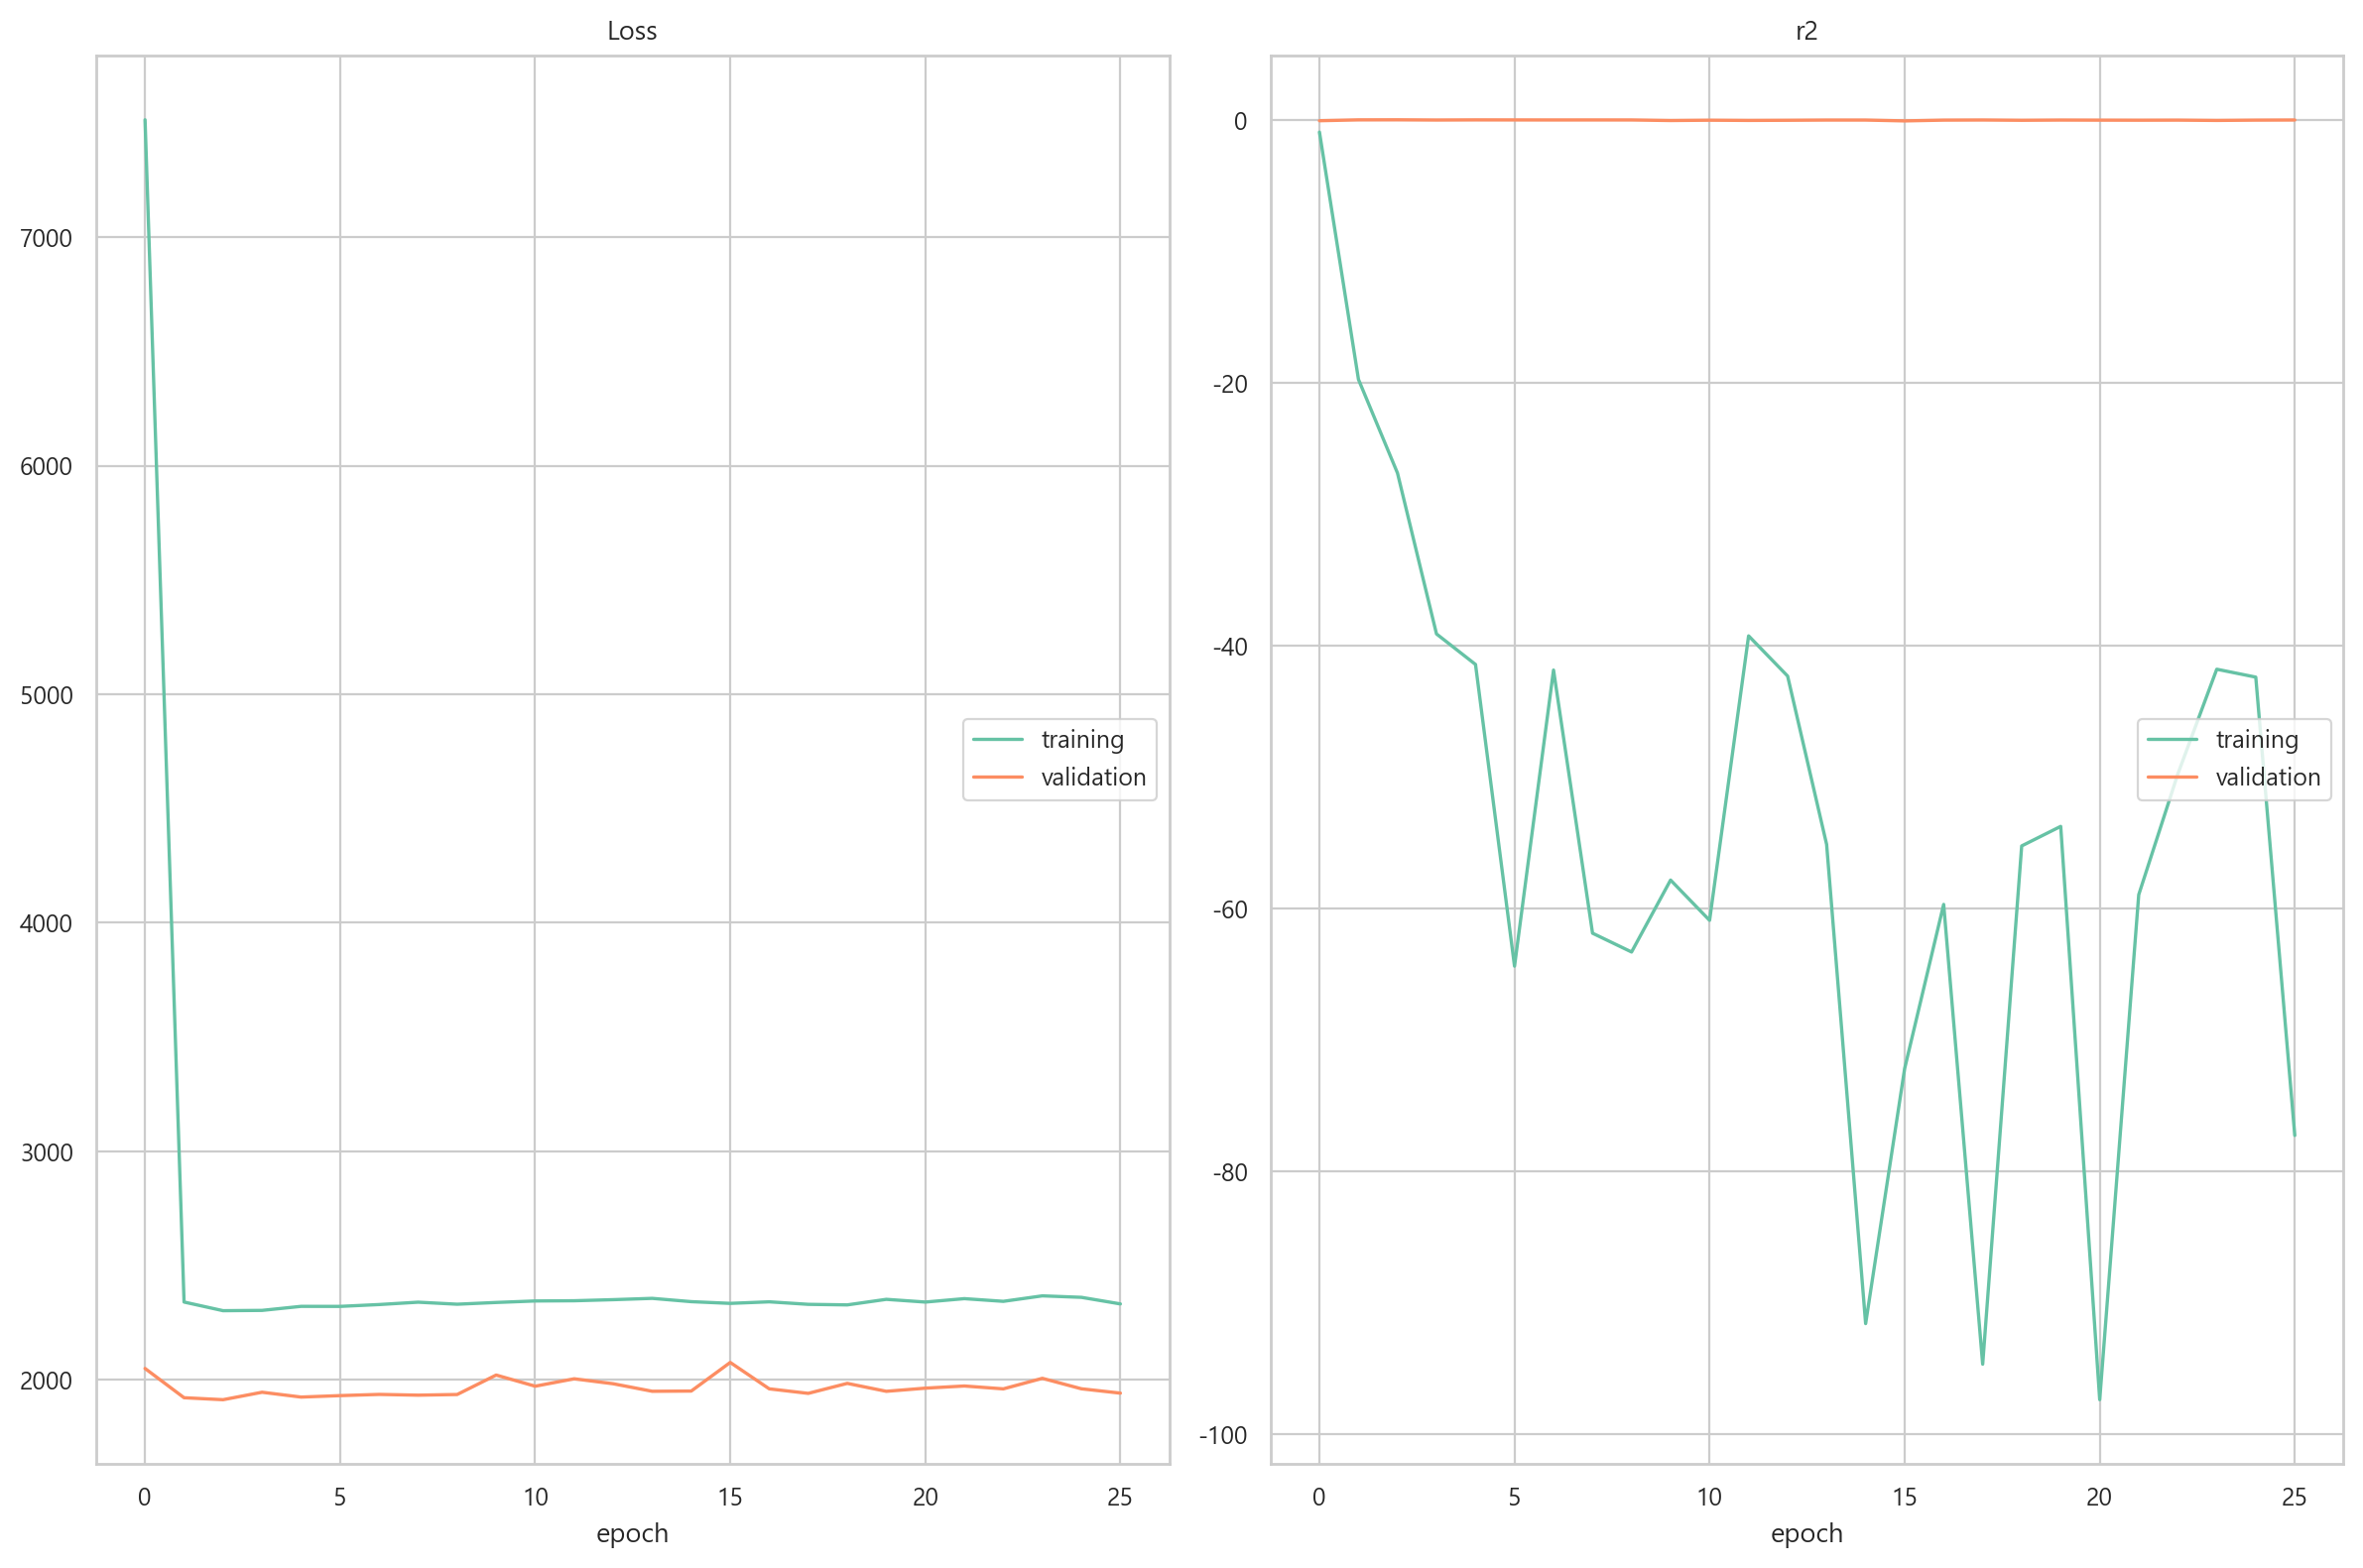

 26%|██▌       | 26/100 [00:31<01:19,  1.08s/it]t:\miniconda3\envs\wassup_pr1\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 26%|██▌       | 26/100 [00:31<01:29,  1.21s/it]


KeyboardInterrupt: 

In [53]:
result_combined = dict()
for lr in [1e-2,1e-3,1e-4]:
    for h in [True,False]:
        path = f'results/mlp/result_reindex_{lr}_h.pkl' if h else f'results/mlp/result_reindex_{lr}.pkl'
        if lr not in result_combined.keys():
            result_combined[lr] = dict()
        
        result_combined[lr][h] = train_eval(target_list,h,lr,save_path=path)

In [ ]:
with open('results/mlp/mlp_reindex.pickle','wb') as fw:
        pickle.dump(result_combined, fw)

In [20]:
def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict):
    flat_dict = flatten_dict(values_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    df = df.unstack(level=-1)
    df.columns = df.columns.map("{0[1]}".format)
    return df

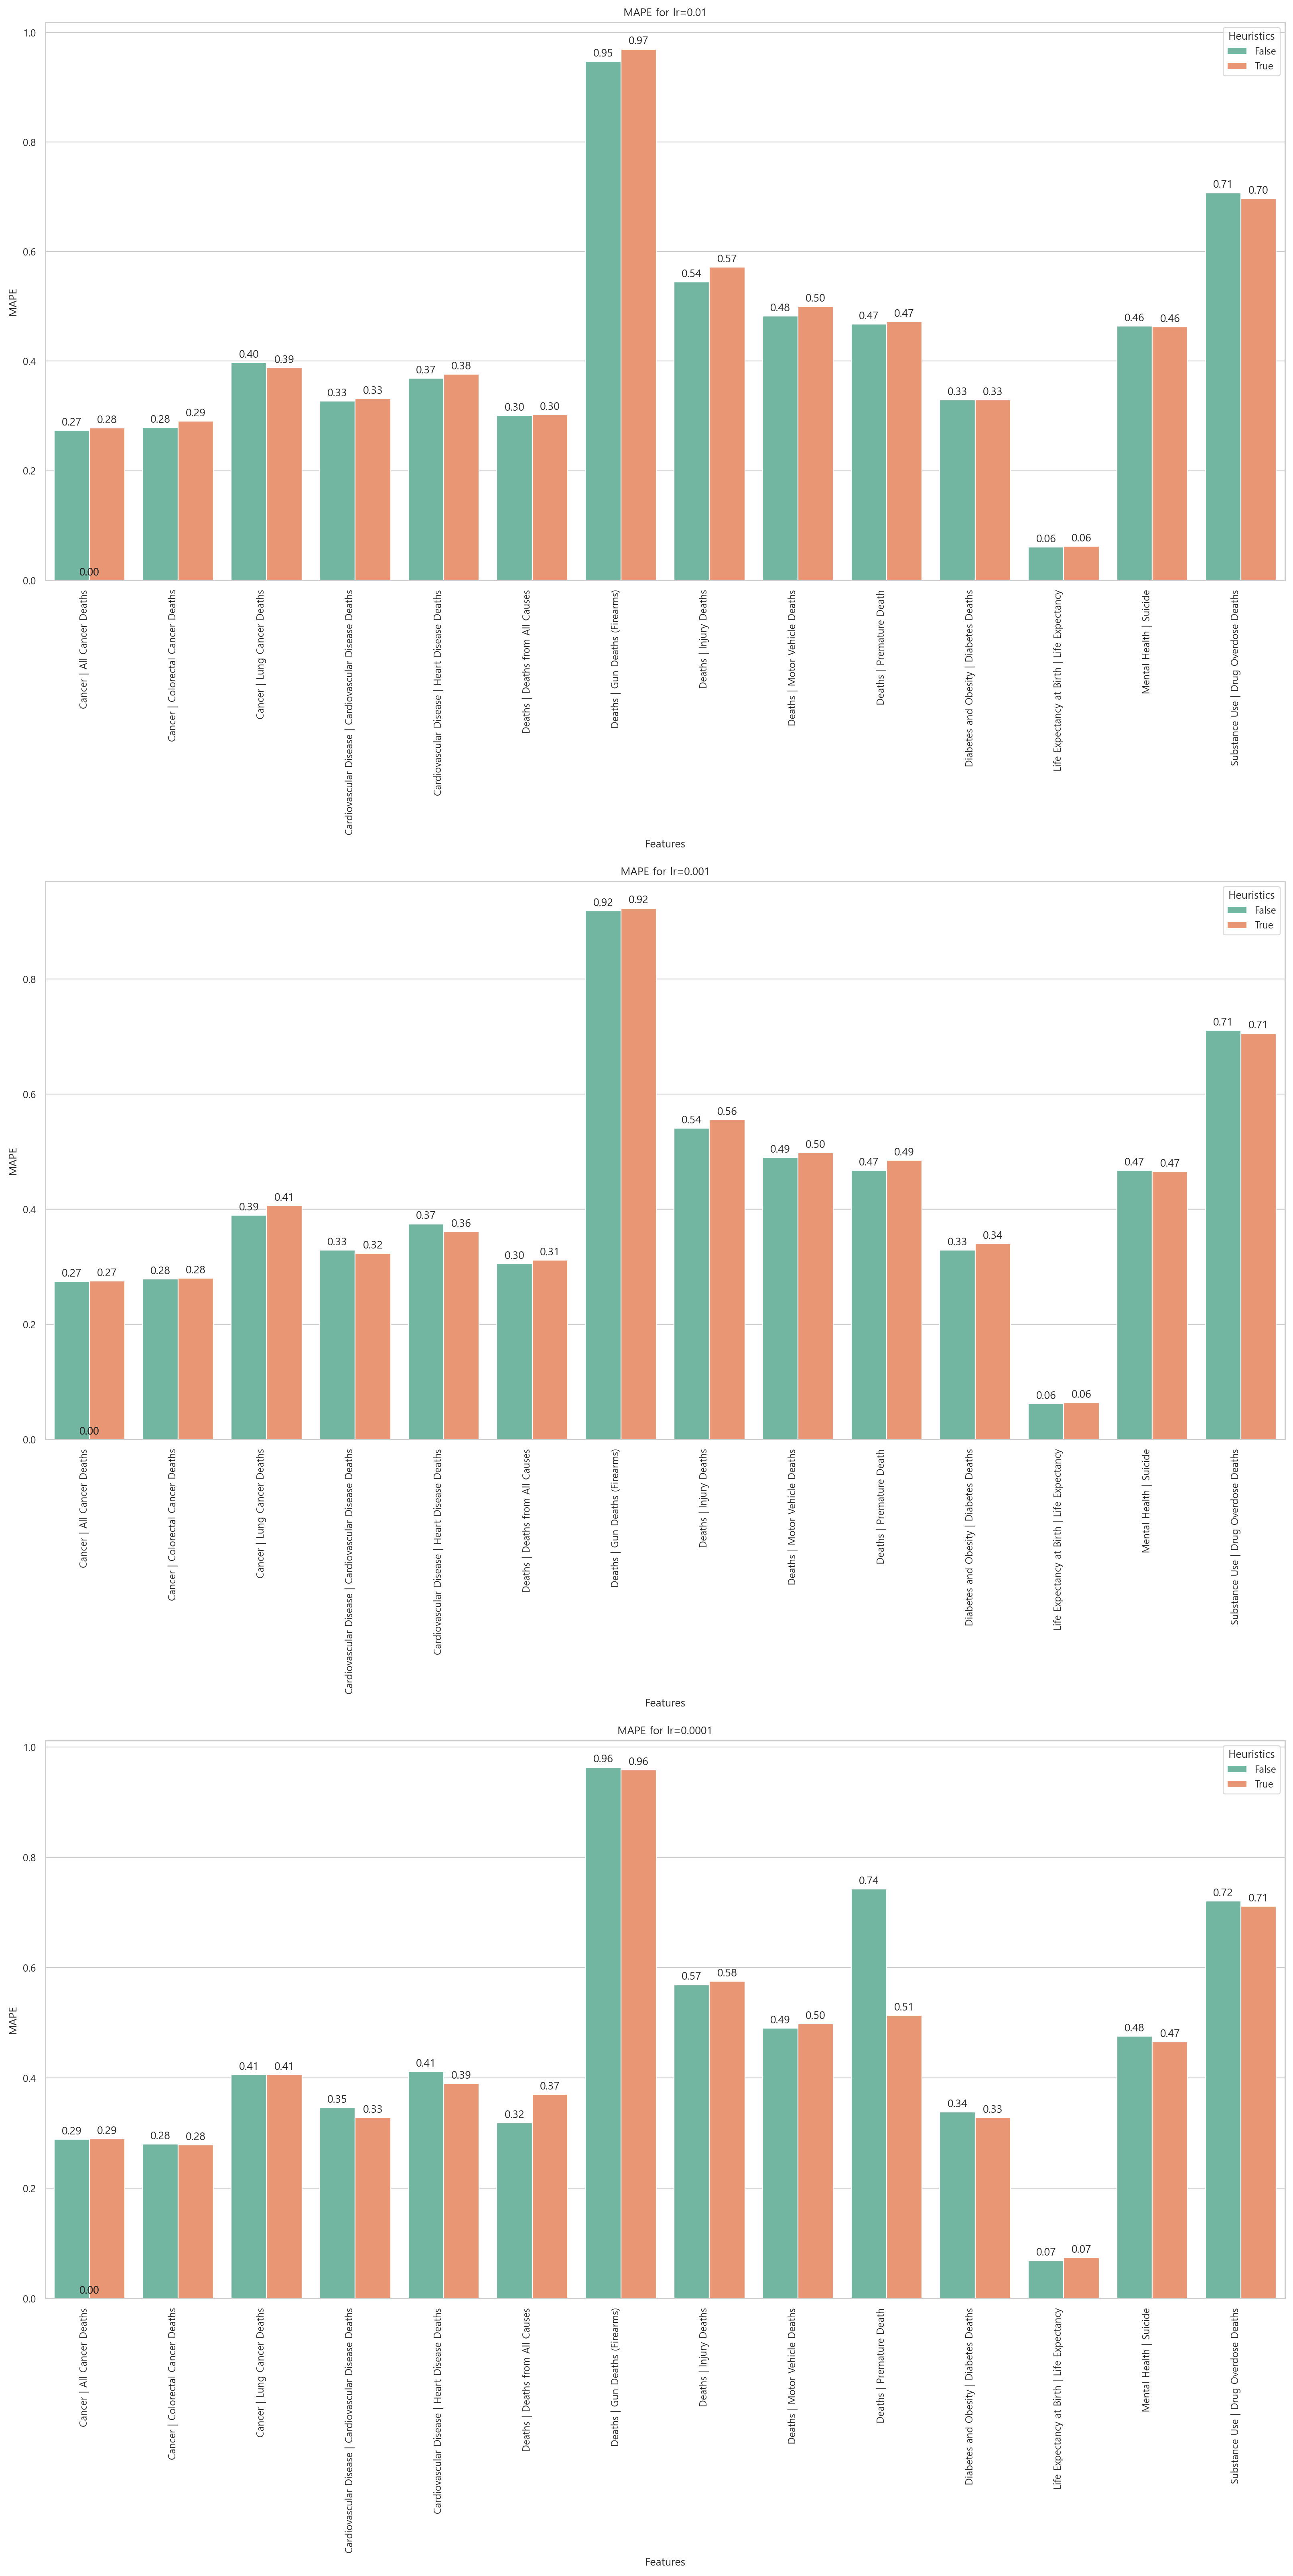

In [22]:
import seaborn as sns
fig ,axes = plt.subplots(3,1,figsize=(16,32))



for idx, key in enumerate(result_combined.keys()):
    data_dict = result_combined[key]
    keys = data_dict.keys()

    df_dict = nested_dict_to_df(data_dict).reset_index()
    df_dict = df_dict.rename(columns={"level_0": "Heuristics","level_2": "mode"})
    df_dict = df_dict[df_dict["mode"] == "test"]
    # pd.DataFrame.from_dict()

    sns.barplot(data=df_dict,x='level_1', y='mape', hue = 'Heuristics', ax=axes[idx])
    axes[idx].set_xticks(axes[idx].get_xticks(), axes[idx].get_xticklabels(), rotation=90, ha='right')

    axes[idx].set(xlabel="Features",ylabel="MAPE",title=f"MAPE for lr={key}")

    for p in axes[idx].patches:
        axes[idx].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext =(0, 7), textcoords='offset points')
    
plt.savefig('mape.png')

In [19]:
with open('results/mlp/mlp_reindex.pickle','wb') as fw:
        pickle.dump(result_combined, fw)

In [118]:
result_dict

{'Cancer | All Cancer Deaths': {'train': {'mse': 903.32587,
   'rmse': 30.05538,
   'r2': -4.140355515069773},
  'test': {'mse': 1035.9961, 'rmse': 32.186893, 'r2': -4.292562329088943}}}

## Bagging

t:\miniconda3\envs\wassup_pr1\lib\site-packages\livelossplot\outputs\matplotlib_plot.py:103: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


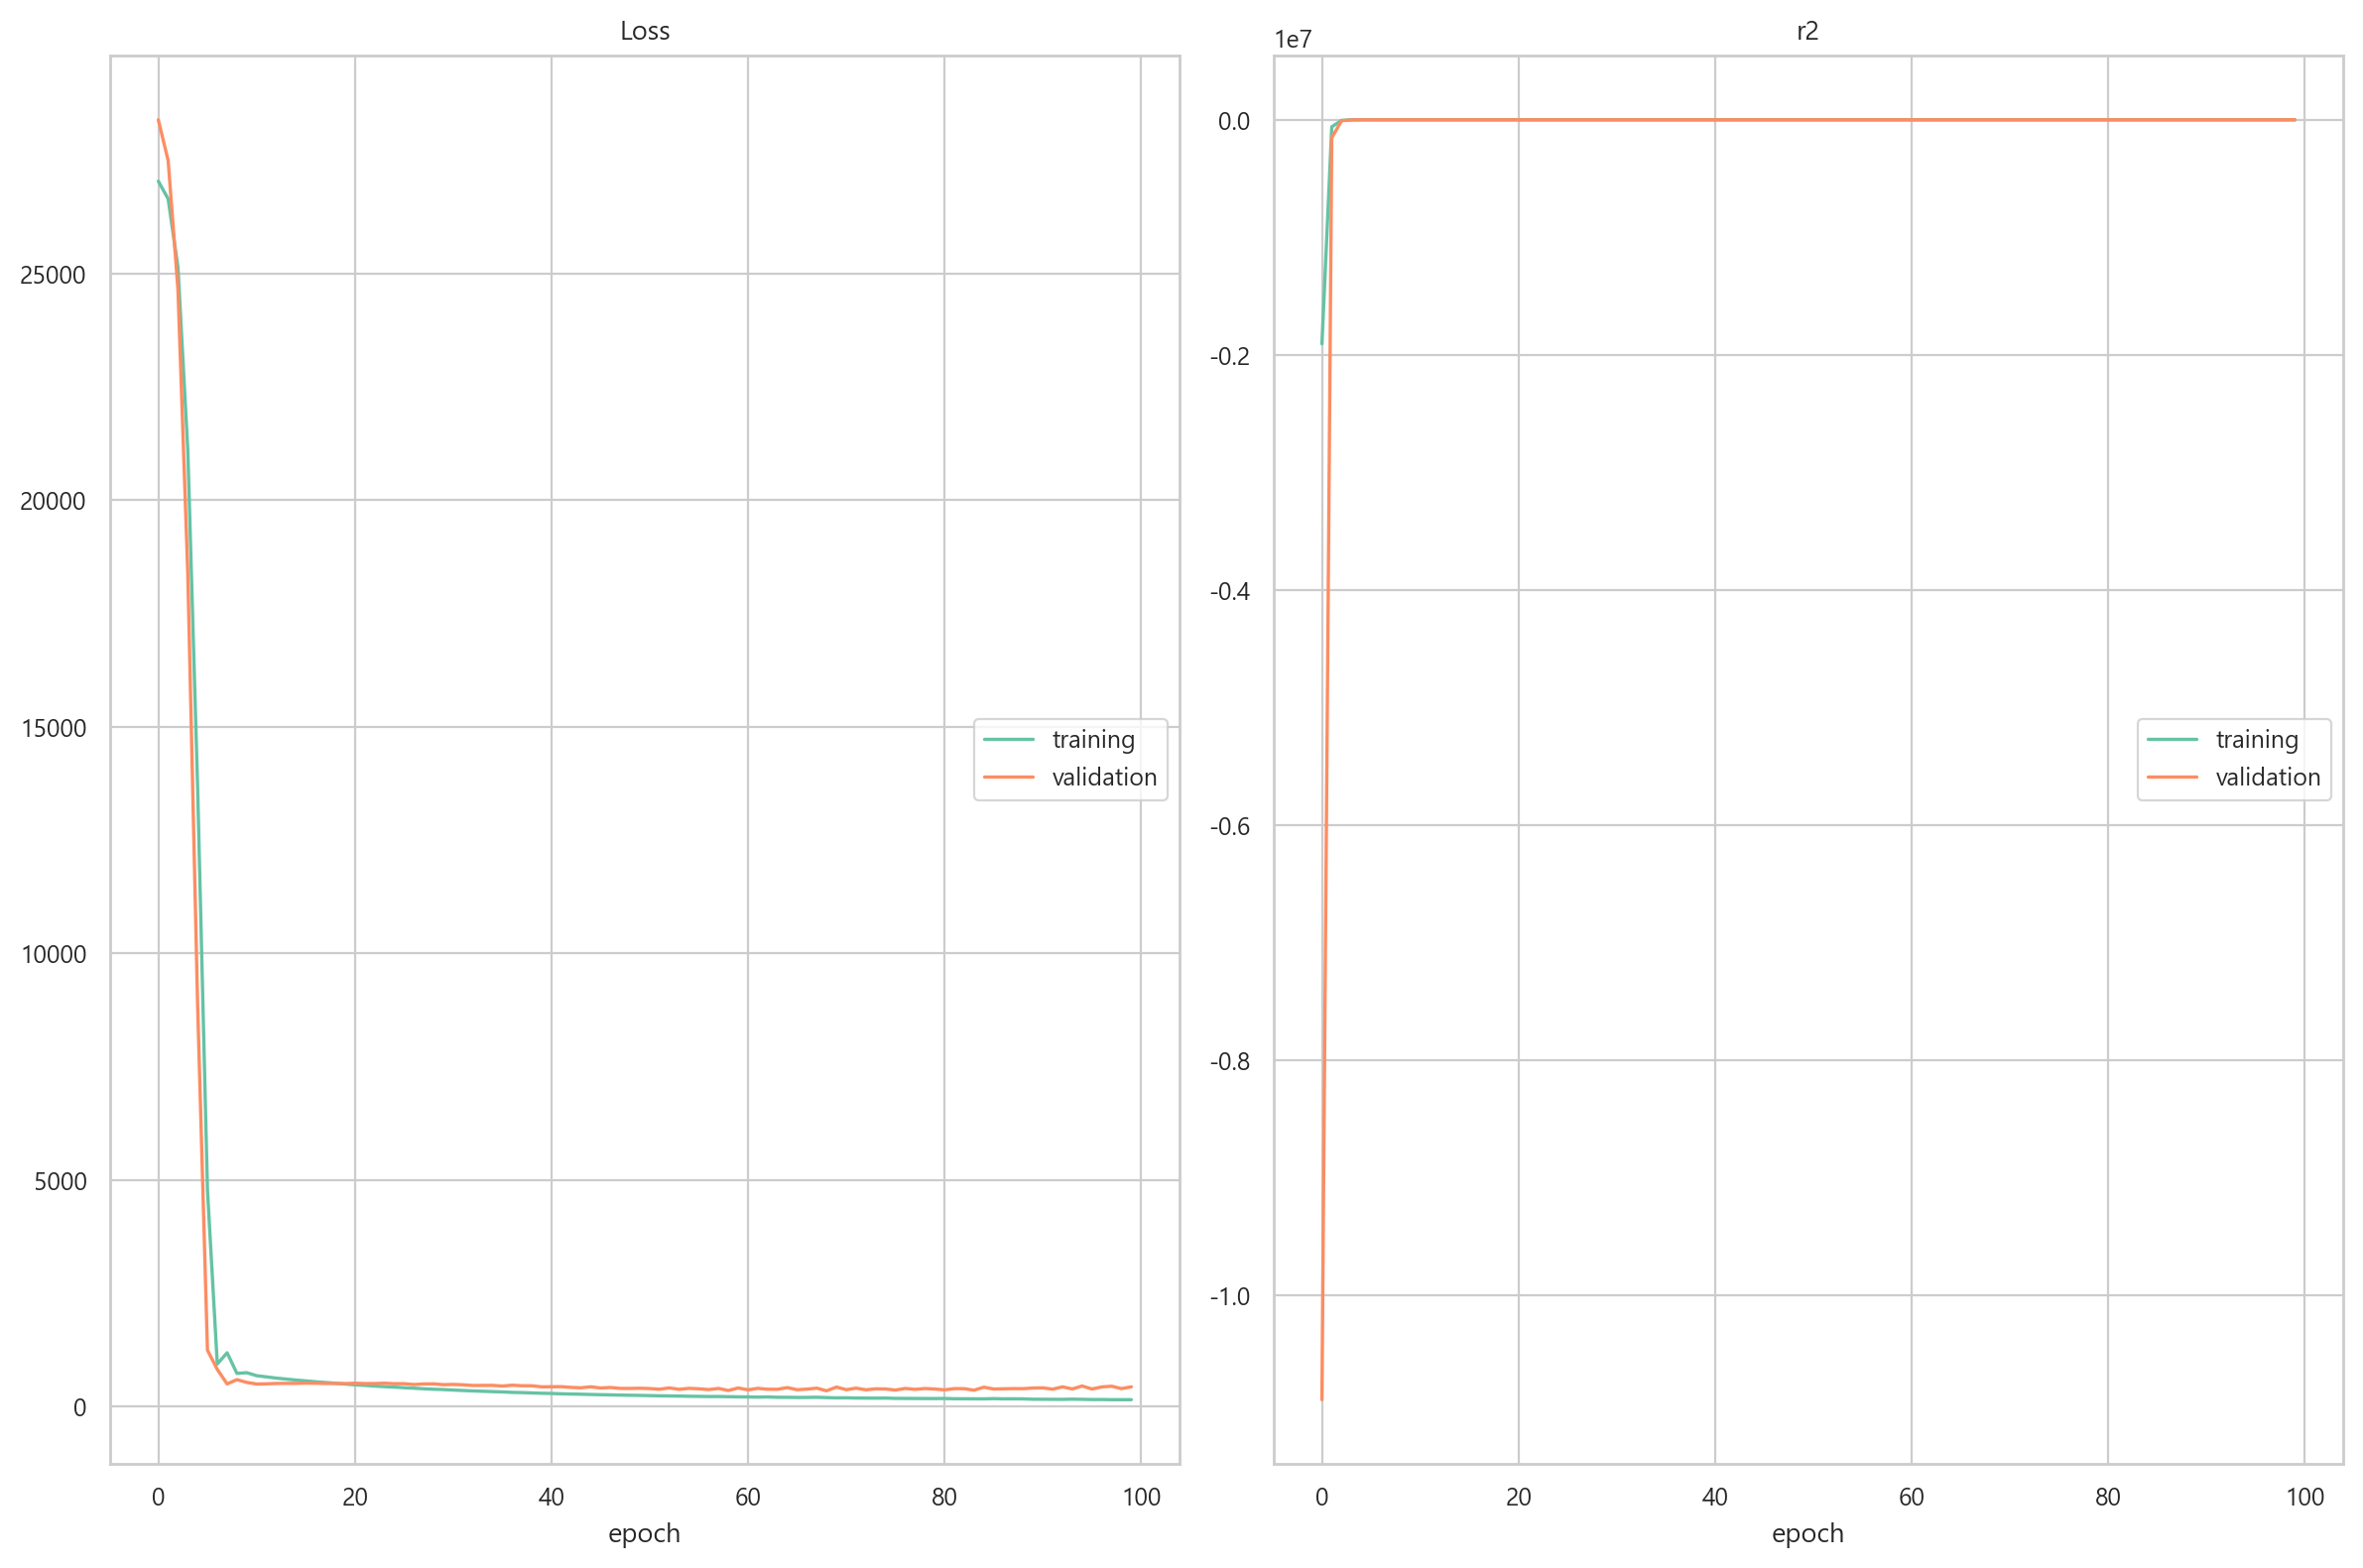

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


In [ ]:
from livelossplot.outputs import MatplotlibPlot
from livelossplot import PlotLosses
from tqdm import tqdm, trange

bagging = 5
best_metric = 99999

for bag_idx in range(bagging):
    bagging_idx = np.random.choice(x_train.index,int(len(x_train) * 0.9))
    bag_train_dataset = CityData(x_train.iloc[bagging_idx,:], y_train.iloc[bagging_idx,:])
    bag_train_loader = DataLoader(bag_train_dataset, batch_size=32, shuffle=True)

    model = MLPRegressor()
    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
    # optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, weight_decay  = 0.9)

    input_shape = len(x_train.columns)
    model.fc1 = nn.Linear(input_shape,50)

    train_loss = list()
    n_epoch = 100

    plotlosses = PlotLosses(outputs=[MatplotlibPlot(figpath =f"lossplot_mlp_bag{bag_idx}.png")])
    # plotlosses = PlotLosses()

    for epoch in trange(n_epoch):
        model.train()
        answer = torch.tensor([])
        prediction = torch.tensor([])
        for idx, data in enumerate(bag_train_loader):
            x, y = data

            optimizer.zero_grad()
            yhat = model(x)

            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()


            prediction = torch.cat((prediction,yhat),0)
            answer = torch.cat((answer,y),0)
        
        prediction = prediction.detach().numpy()
        answer = answer.numpy()
        train_loss = mean_squared_error(answer,prediction)
        train_r2 = r2_score(answer,prediction)

        model.eval()
        answer = torch.tensor([])
        prediction = torch.tensor([])
        with torch.no_grad():
            for idx, data in enumerate(val_loader):
                x, y = data
                yhat = model(x)

                prediction = torch.cat((prediction,yhat),0)
                answer = torch.cat((answer,y),0)
        prediction = prediction.detach().numpy()
        answer = answer.numpy()
        val_loss = mean_squared_error(prediction, answer)
        val_r2 = r2_score(answer,prediction)

        path = f'./{bag_idx}_best.pt'
        if best_metric > val_loss:
            best_metric = val_loss
            torch.save(model.state_dict(), path)
            print(best_metric, 'Saving to', path)

        plotlosses.update({
            'loss': train_loss,
            'val_loss': val_loss,
            'r2' : train_r2,
            'val_r2' : val_r2
        })
        plotlosses.send()


In [ ]:
# models = []
# for i in range(bagging):
#     try:
#         models.append(MLPRegressor().load_state_dict(torch.load(f'./{i}_best.pt')))
#     except:
#         continue

model_0 = MLPRegressor()
model_0.load_state_dict(torch.load(f'./0_best.pt'))

model_1 = MLPRegressor()
model_1.load_state_dict(torch.load(f'./1_best.pt'))

model_2 = MLPRegressor()
model_2.load_state_dict(torch.load(f'./2_best.pt'))

model_4 = MLPRegressor()
model_4.load_state_dict(torch.load(f'./4_best.pt'))

models = [model_0,model_1,model_2,model_4]

answer = torch.tensor([])
prediction = torch.tensor([])
with torch.no_grad():
    for idx, data in enumerate(test_loader):
        yhats = list()
        x, y = data
        for model in models:
            model.eval()
            yhats.append(model(x))
        yhat = torch.mean(torch.stack(yhats,dim=1),dim=1)
        # print(x)

        prediction = torch.cat((prediction,yhat),0)
        answer = torch.cat((answer,y),0)
prediction = prediction.detach().numpy()
answer = answer.numpy()
test_mse = mean_squared_error(prediction, answer)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(prediction, answer)

print(test_mse)
print(test_rmse)
print(test_r2)

651.25287
25.519657
-1.368276870440703


In [ ]:
for model in models:
    model.eval()
    answer = torch.tensor([])
    prediction = torch.tensor([])

    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            yhats = list()
            x, y = data
            yhat = model(x)
            # print(x)

            prediction = torch.cat((prediction,yhat),0)
            answer = torch.cat((answer,y),0)
    prediction = prediction.detach().numpy()
    answer = answer.numpy()
    test_mse = mean_squared_error(prediction, answer)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(prediction, answer)

    print(test_mse)
    print(test_rmse)
    print(test_r2)

592.2932
24.337074
-1.1864823261253736
526.39185
22.943232
-0.896362043752936
1548.452
39.350376
-1.4709321930470738
463.37128
21.52606
-0.11640853330002732
